# Global Societal Endangerment Index (GSEI)

Development notebook

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry

# Data Loading and Preprocessing
Bring datasets into the right format and merge them into one dataframe.

In [2]:
def all_countries():
    return [c.name for c in pycountry.countries]

def standardise_countries(country_col: pd.Series):
    return country_col.map(pycountry.countries.lookup).map(lambda country: country.name)

In [13]:
# environmental data
# start with comprehensive country list
env_data = pd.DataFrame(all_countries(), columns=['Country'])

env_data

,Country
0,Aruba
1,Afghanistan
2,Angola
3,Anguilla
4,Åland Islands
...,...
244,Samoa
245,Yemen
246,South Africa
247,Zambia


In [15]:
# Climate Change Vulnerability

# Maximum relative temperature change (°C) in the last 10 years, compared to a 1951-1980 baseline
temp_change = pd.read_csv("data/UN_FAO_climate_change_indicators.csv")
# drop row with Country 'world' in temp_change
temp_change = temp_change[temp_change['Country'] != 'World']
# standardise country names
temp_change['Country'] = standardise_countries(temp_change['ISO3'])
# INDICATOR: calculate maximum value between F2012 and F2022
temp_change['Temp Change max 2012-2022'] = temp_change[['F2012', 'F2013', 'F2014', 'F2015', 'F2016', 'F2017', 'F2018', 'F2019', 'F2020', 'F2021', 'F2022']].max(axis=1)
# merge
if 'Temp Change max 2012-2022' not in env_data.columns:
    env_data = env_data.merge(temp_change[['Country', 'Temp Change max 2012-2022']], on='Country', how='left')

print(env_data.columns.values)

['Country' 'Temp Change max 2012-2022']


In [7]:
env_data

,Country,Temp Change max 2012-2022
0,Aruba,1.303
1,Afghanistan,2.012
2,Angola,1.752
3,Anguilla,1.224
4,Åland Islands,NaN
...,...,...
244,Samoa,1.440
245,Yemen,NaN
246,South Africa,1.811
247,Zambia,1.450


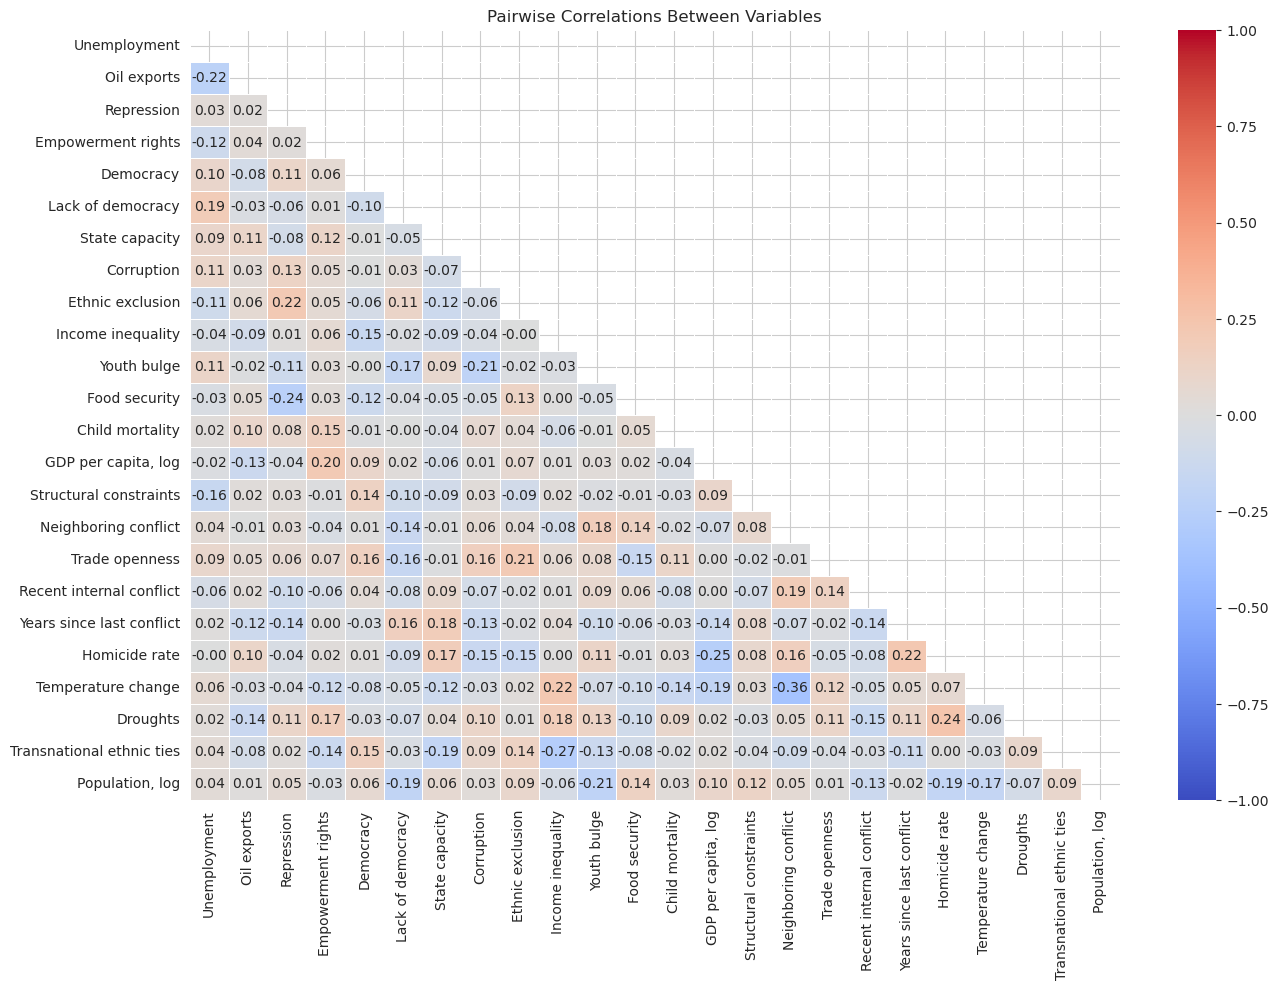

In [7]:
### Heatmap Correlation Matrix

# Create dummy data (replace with your actual data)
np.random.seed(42)
data = np.random.rand(100, 24)  # 100 rows, 24 columns
columns = ['Unemployment', 'Oil exports', 'Repression', 'Empowerment rights', 'Democracy', 'Lack of democracy',
           'State capacity', 'Corruption', 'Ethnic exclusion', 'Income inequality', 'Youth bulge',
           'Food security', 'Child mortality', 'GDP per capita, log', 'Structural constraints',
           'Neighboring conflict', 'Trade openness', 'Recent internal conflict', 'Years since last conflict',
           'Homicide rate', 'Temperature change', 'Droughts', 'Transnational ethnic ties', 'Population, log']
df = pd.DataFrame(data, columns=columns)

# Calculate correlation matrix
correlation_matrix = df.corr()

# Create heatmap with mask
plt.figure(figsize=(15, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
plt.title("Pairwise Correlations Between Variables")
plt.show()